# STiCKY REVIEWS
#### Navit Dori Capstone Project

As a frequent online shopper I rely heavily on consumer reviews to help me with my shopping.
I have sometimes detected similariteis between consequtive reviews. The similarities were in both text and score. This phenomenonn raised several intriguing questions: is this a measurable effect? Does it reflect a temporary problem with the probduct or is there something in the first review that compelles others to imitate it? Do these reviews have common features?

In this project I define sticky reviews as reviews that start a time-window of low average score. I use Amazon reviews data to measre how common "sticky" reviews are and to detect their common features. This work concentrates on "sticky" reviews that lower the average score although the same analysis may be applied to uncommonly good reviews that raise the average score. 

A temporal decrease in a product score is naturally very important to the seller, whether it is caused by a problem in the product, a competition attack that attempts to lower the score by posting fake reviews, or a bad review that influences others to imitate it. Speaking for myself, the possibility of reviews influencing following reviewers is interesting as a research in human behavior. I am very curious to find out if there are features or attributes of a reviews that can be shown to cause "stickiness".



## Identifying the "sticky" reviews

I used [Amazon reviews data of electronic products](http://jmcauley.ucsd.edu/data/amazon/) consisting of 1,689,188 reviews. I chose to concentrate on electronics because they tend to have a higher price and presumably people invest some effort to research before they buy them.
 
I focused on highly scoring products (average score 3.5 and up) with more than 50 reviews. I identify two types of reviews:
1. "Dip" reviews: reviews with an exceptional low score (1.5 points lower than that product's average score). 
2. "Sticky" reviews: dip reviews that have an exceptionally low score in a review-window after it.

Thus, "sticky" reviews start a sequence of similarly low score reviews, and cause the average score to decrease temporarily. 



I assume a null hypothesis of no time correlations in the data. The histogram of the shuffled data represents the probability of seeing a given window average score under this hypothesis. 
In the following graph I plot the histogram of the shuffled data in red, and the histogram of the data in green. 
The real data histogram has a lower average and a longer left tail. I conclude that there are time correlations in the data. I defined as "sticky" all reviews with window average score at least 1 point lower than the average score. 
These correspond to the revies at the left tail of the graph, where the probability of encountering such a low score by chance is 20%. The time window here is a window of 5 reviews after the dip review.


###### upload longRev2

In [ ]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_file, show
import numpy as np
import pandas as pd
import pickle
import json
import statistics

''' loading data from files'''       
file0 = open("ElongRev2_beforehist.pkl","rb")
longRev2 = pickle.load(file0)
file0.close()



In [2]:
len(longRev2)

889708

### making the shuffled data:

In [19]:
import random
def add_shuff_col(longRev2, comp_name,w):
    add_col = 'shuffled_'+comp_name
    longRev2.loc[:,add_col]  = [0.0]*len(longRev2)
    asin_list = list(longRev2['asin'].unique() )
    list_rand_indices = []
    #temp_list = []
    for name in asin_list:
        indices_of_name = longRev2[longRev2['asin']==name].index.values
        for ind in indices_of_name:
            shuff_wavg = np.mean( longRev2.loc[ np.random.choice( indices_of_name, w ) ,
                                                    comp_name].values )
            #temp_list.append(shuff_wavg)
            #add columns to longRev2: 'shuffled_wavg'
            longRev2.at[ind, add_col]     = float( shuff_wavg )    
    return( longRev2, add_col)

In [ ]:
w=5 #size of time-window
comp_name = 'wavg'# = shuff_name
longRev2, add_col = add_shuff_col(longRev2, comp_name,w)

In [21]:
''' saving to files'''       
#file10 = open("ElongRev2_with_shuffled_wavg.pkl","wb")
#pickle.dump(longRev2,file10)
#file10.close()


### Plotting the histogram

###### Uploading longRev2 with shuffled window average

In [3]:

import numpy as np
import pandas as pd
import pickle
import json
import statistics

''' loading data from files'''       
file0 = open("ElongRev2_with_shuffled_wavg.pkl","rb")
longRev2 = pickle.load(file0)
file0.close()


###### Histogram calculaltion

      wavg  shuffled_wavg
min   1.00           1.84
max   4.60           5.00
mean  3.70           4.15
std   0.63           0.44


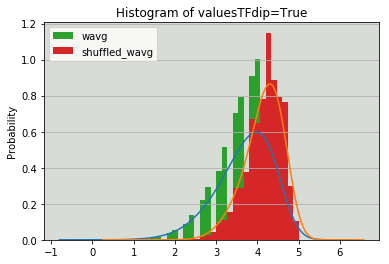

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def hist_comp_col(longRev2, col1, col2, choose_True, Nhistbins):
    df4hist = pd.concat( [longRev2.loc[longRev2[choose_True] == True, col1],
                        longRev2.loc[longRev2[choose_True] == True, col2] ], axis=1, 
                    )
    df4hist.columns = [col1, col2]
    
    #plotting two histograms on the same grid:
    fig, ax = plt.subplots()
    df4hist.plot.kde(ax=ax, legend=False, title='Histogram of values'+choose_True+'=True', bw_method=0.5)
    df4hist.plot.hist(density=True, ax=ax, bins = Nhistbins)
    ax.set_ylabel('Probability')
    ax.grid(axis='y')
    ax.set_facecolor('#d8dcd6')
    print( df4hist.agg(['min', 'max', 'mean', 'std']).round(decimals=2) ) 
    return(df4hist, df4hist.agg(['mean']).round(decimals=2) )


Nhistbins = 30 #numbre of bins in histogram
col1 = comp_name
col2 = add_col
choose_True = 'TFdip'
_, hist_mean = hist_comp_col(longRev2, col1, col2, choose_True, Nhistbins)

###### definition of sticky

Out of 889,708 reviews there are 134,104 reviews that are "dip" reviews, whose score is at least 1.5 points lower than the product's average score. I define as "sticky" as "dip" reviews with window average score at least 1 point lower than the mean window average score (3.70 as calculated above).

In [18]:
dip_for_sticky = hist_mean.wavg.values[0] - 1
longRev2['TFsticky'] =  longRev2.loc[longRev2['TFdip']==True].wavg< dip_for_sticky


There are 134,104 "dip" reviews
and 10,466 "sticky" reviews

In [21]:
''' saving to files corrected definition of sticky'''       
#file10 = open("ElongRev2_with_TFsticky.pkl","wb")
#pickle.dump(longRev2,file10)
#file10.close()


## Word cloud of the "sticky" reviews

I continue with calculating the TF-IDF matrices of the sticky versus the dip reviews and pltting them in a word cloud.
For this I use NLTK and Gensim. I use Porter stemmer for stemming. However, because stemmed tokens are not human friendly, I retain the original tokens and use them for presentation in the word cloud.
The word cloud uses weights of the stemmed tokens but choses the most-frequent token that contributed to the stemmed token for presentation.

###### Uploading longRev2 with "TFsticky" review column
TFsticky column: True if stickay, False if dip but not sticky, NaN otherwise'

In [22]:
import numpy as np
import pandas as pd
import pickle
import json
import statistics

'''upload longRev2 again, corrected definition of sticky'''
file0 = open("ElongRev2_with_TFsticky.pkl","rb")
longRev2 = pickle.load(file0)
file0.close()


###### Word Cloud Calculation

In [35]:
import sys
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

#nltk.download('stopwords')


In [36]:
def get_common_surface_form(original_corpus, stemmer):
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}

    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1

    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, 
                                     key=lambda i: originals[i])

    return surface_forms


In [37]:
def gen_weights4word_cloud(datadf):
    # expect a pandas series of text
    stemmer = PorterStemmer() # Stemmer for reducing terms to root form 
    stemmed_corpus = []       # For storing the stemmed tokens 
    original_corpus = []      # For storing the non-stemmed tokens


    for rev in datadf:    #iterate over reviews
        contents = rev.lower() # Load file contents
        tokens = word_tokenize(contents)     # Extract tokens
        stemmed = [stemmer.stem(token) for token in tokens] # Stem tokens
        stemmed_corpus.append(stemmed)    # Store stemmed document
        original_corpus.append(tokens)    # Store original document

    dictionary = Dictionary(stemmed_corpus) # Build the dictionary
    # Get the surface form for each stemmed word
    counts = get_common_surface_form(original_corpus, stemmer)
    # Convert to vector corpus
    vectors = [dictionary.doc2bow(text) for text in stemmed_corpus]
    # Train TF-IDF model
    tfidf = TfidfModel(vectors)
    # Get TF-IDF weights (a list of tuples (#, frequency))
    weights = tfidf[vectors[0]]
    # Replace term IDs with human consumable strings
    weights = [(counts[dictionary[pair[0]]], pair[1]) for pair in weights]
    weights = dict(weights)
    return weights


In [38]:
def gen_word_cloud(weights, wctitle): #expects a dictionary {word:frequency}
    # Initialize the cloud
    wc = WordCloud(
        background_color="white",
        max_words=2000,
        width=1024,
        height=720,
        stopwords=stopwords.words('english')
    )

    # Generate the cloud
    wc.generate_from_frequencies(weights)

    # Save the cloud to a file
    #wc.to_file("word_cloud.png") 

    # Display the generated image:
    plt.imshow(wc, interpolation='bilinear')
    plt.title(wctitle)
    plt.axis("off")
    plt.show()


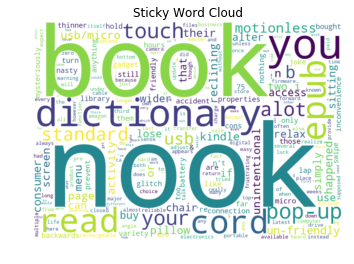

In [9]:
sticky_ser = longRev2.reviewText[longRev2.TFsticky==True]
weights_sticky = gen_weights4word_cloud(sticky_ser)

gen_word_cloud(weights_sticky, 'Sticky Word Cloud')
''' saving the tfidf results'''       
file12 = open("Eweights_sticky.pkl","wb")
pickle.dump(weights_sticky,file12)
file12.close()


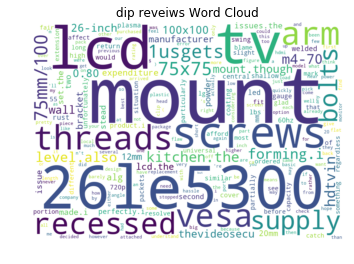

In [39]:
#compare sticky reviews to 

dip_ser = longRev2.reviewText[longRev2.TFsticky==False] #includes dip and nondip

weights_dip = gen_weights4word_cloud(dip_ser)

gen_word_cloud(weights_dip,'dip reveiws Word Cloud')

''' saving the tfidf results'''       
file13 = open("Eweights_dip.pkl","wb")
pickle.dump(weights_dip,file13)
file13.close()
